In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow_addons as tfa
import time


C:\Users\tobia\anaconda3\envs\gpu_test\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201205). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [42]:
tf.__version__

'2.5.0-dev20201205'

In [2]:
#Kode til at kører på gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Load Data

In [3]:
#Finder datasættets placering
import pathlib
data = "data"
data_dir = pathlib.Path(data)
type(data_dir)


pathlib.WindowsPath

In [4]:
#Kontrollere om der ligger billeder på placer
image_count = len(list(data_dir.glob('*/*/*.png')))
print(image_count)

35941


In [5]:
#Laver et tensorflow dataset med stier til vores data, for både vores trænnings- og validerings data
#Train
train_ds = tf.data.Dataset.list_files(str(data_dir/'train/*/*'), shuffle=False)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Val
val_ds = tf.data.Dataset.list_files(str(data_dir/'val/*/*'), shuffle=False)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=False)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
type(train_ds)

28763
3589


tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [6]:
#Ser om vi data'en er importeret korrekt
for f in train_ds.take(5):
    print(f.numpy())

b'data\\train\\Fear\\16005.png'
b'data\\train\\Angry\\26337.png'
b'data\\train\\Surprise\\26010.png'
b'data\\train\\Sad\\5663.png'
b'data\\train\\Angry\\3822.png'


In [7]:
#Laver en liste over de forskellige kategorier
class_names = np.array(sorted([item.name for item in data_dir.glob('train/*')]))
print(class_names)

['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [8]:
num_classes = len(class_names)

In [9]:
batch_size = 64
img_height = 48
img_width = 48

# process path???

In [10]:
#Viser et billede før og efter augmentation
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original.numpy().astype("uint8"),cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented.numpy().astype("uint8"),cmap='gray')

In [11]:
def get_label(file_path):
  #Splitter en sti ved brug af en 'path seperator'. Laver en liste af 'path components'
  parts = tf.strings.split(file_path, os.path.sep)
  #Tager den næst sidste i vores liste som svarer til vores klasses fil placeringen
  one_hot = parts[-2] == class_names
  #Integer encode the label
  return tf.argmax(one_hot)

In [12]:
def decode_img(img):
  #Konvertere til uint8 tensor = Defaults to tf.uint8.
  img = tf.image.decode_png(img, channels=1)
  #Ændre størrelse på vores billede
  return tf.image.resize(img, [img_height, img_width])

In [13]:
#Denne funktion bruger de to overstående funktioner
def process_path(file_path):
    label = get_label(file_path)
  #Loader vores data
    img = tf.io.read_file(file_path)
    img = decode_img(img)
  #Return billede med et tilhørende label
    return img, label

In [14]:
# Ved brug af .map, så bruges funktionen process_path på alle elementerne i vores datasets.
# Load/process billederne parallelt med num_parallel_calls
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (48, 48, 1)
Label:  2


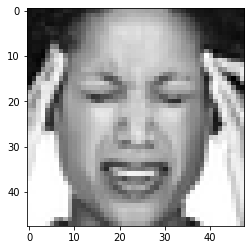

In [15]:
#Vis et billede fra træningsdataen med det tilhørende label
for image, label in train_ds.take(1):
    plt.imshow(image.numpy().astype("uint8"),cmap='gray')
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# Augment

In [16]:
def shear(image):
    #shear
    random_number_shear = random.uniform(-0.3,0.3)
    shear = random_number_shear
    shear_rotate = shear * -20
    image = tfa.image.transform(image, [1.0, shear, shear_rotate, 0.0, 1.0, 0.0, 0.0, 0.0])
    return image


In [17]:
def crop(image):
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[img_height, img_width, 1])
    return image

In [18]:
def distortion(image):
    #distortion
    random_number_distortion = random.uniform(0,5)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=random_number_distortion, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

In [19]:
def flip(image):
     #Flip    
    random_number_flip = random.uniform(0,2)
    if random_number_flip > 1:
        image = tf.image.flip_left_right(image)
    return image

In [20]:
def brightness(image):
    image = tf.image.random_brightness(image, max_delta=0.5) 
    return image

In [21]:
#kode hvor alt augment sker
def augment(image,label):
    image = shear(image)
    image = flip(image)
    image = brightness(image)
    image = distortion(image)
    image = crop(image)
    return image, label

In [22]:
#Vi deler train og val ind i batches og blander dem
print(train_ds)    
train_ds = (
    train_ds
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)    
#Gemmer en kopi af train_ds så vi har en ikke augmentered version.
orgDataset = train_ds
print(train_ds)

val_ds = (
    val_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

<ParallelMapDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 48, 48, 1), (None,)), types: (tf.float32, tf.int64)>


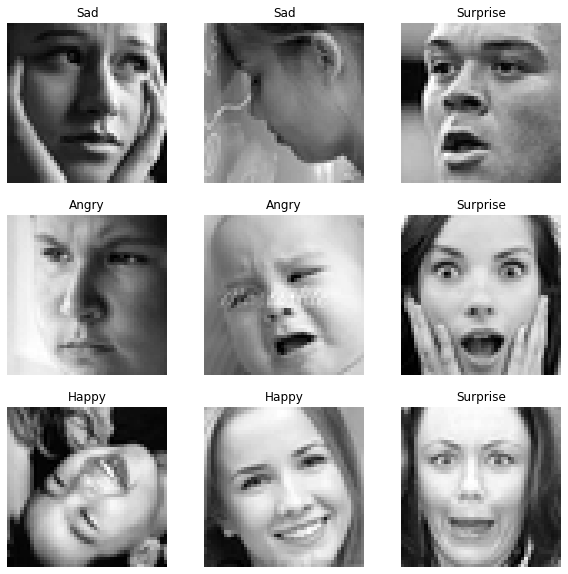

In [23]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")


In [24]:
#Exempler på data augmentation
def flipImage(image):
    flipped = tf.image.flip_left_right(image)
    return flipped
def brightnessImage(image):
    image = tf.image.adjust_brightness(image,0.5)
    return image

tensorflow.python.framework.ops.EagerTensor

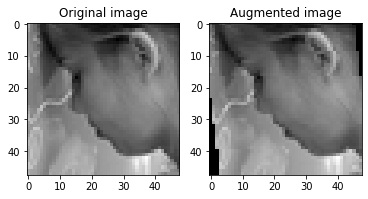

In [25]:
#Kontrol om vores data augmentation virker
image = image_batch[1]
flipped = shear(image)
visualize(image,flipped)
type(image)

# The CNN Model

In [26]:
#I model_checkpoint gemmer vi den bedste val_accuracy vi får under vores træning
class CustomCallback(keras.callbacks.Callback):
   
    def on_epoch_end(self, epoch, logs=None):      
        image_batch, label_batch = next(iter(train_ds))
        plt.figure(figsize=(10, 10))
        for i in range(1):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
            label = label_batch[i]
            plt.title(class_names[label])
            plt.axis("off")
            
checkpoint_filepath = 'save models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
from tensorflow.keras import layers

cnn = tf.keras.models.Sequential([
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Flatten(),
layers.Dense(units=128, activation='relu'),
layers.Dense(units=num_classes,activation='softmax')
])

cnn.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])



In [28]:
from tensorflow.keras import layers

outdated_model = tf.keras.models.Sequential([
layers.experimental.preprocessing.Resizing(48, 48),
layers.experimental.preprocessing.Rescaling(1./255),
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(units=256, activation='relu'),
layers.Dense(units=num_classes,activation='softmax')
])

outdated_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])


In [29]:
#Vi laver vores CNN model og compiler den. Dette layer bruger vi da den var bedre end de forrige

model = tf.keras.models.Sequential([
layers.experimental.preprocessing.Resizing(48, 48,),
layers.experimental.preprocessing.Rescaling(1./255),
layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[48, 48, 1]),
layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
layers.MaxPool2D(pool_size=2, strides=2),
layers.Dropout(0.25),
layers.Flatten(),
layers.Dense(units=1024, activation='relu'),
layers.Dropout(0.50),
layers.Dense(units=num_classes,activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [30]:
#Laver variabler og lister for at kunne visualisere udviklingen
last_25_accuracy = []
accuracy = []
highest_accuracy = 0

last_25_val_accuracy = []
val_accuracy = []
highest_val_accuracy = 0

last_25_loss_ = []
loss_ = []
lowest_loss_ = 100

last_25_val_loss = []
val_loss = []
lowest_val_loss = 100

1/1
450/450 [==============================] - 12s 20ms/step - loss: 1.8011 - accuracy: 0.2574 - val_loss: 1.5385 - val_accuracy: 0.4115
It took 0:0:13
highest_accuracy: 0.29750025272369385 highest_val_accuracy (Epoch: 1) : 0.41153523325920105 lowest_loss: 1.7322636842727661 lowest_val_loss: 1.538456678390503


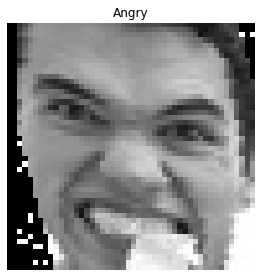

In [31]:
#Laver variabler og lister for at kunne visualisere udviklingen
n_epoch = 1
best_epoch = 0
#Vi bruger kun callback når vi vil gemme en ny model og ikke når vi tester om den er bedre
#callbacks=[model_checkpoint_callback]) 

#Træner vores model i et forloop en epoch af gangen
start = time.time()
for i in range(n_epoch):
    try:
        print(f"{i+1}/{n_epoch}")
        history = model.fit(train_ds, validation_data = val_ds, epochs = 1)
        #Vi unbatcher og blander dataen
        #Derefter augmenterer vi på vores oprindelige dataset (ikke augmenteret). Batcher igen til sidst.
        train_ds = (
            orgDataset
            .unbatch()
            .shuffle(1000)
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
         )
        
        #if statemen som gemmer de værdier nænvt øvest
        if highest_accuracy < history.history['accuracy'][0]:
            highest_accuracy = history.history['accuracy'][0]
            
        if highest_val_accuracy < history.history['val_accuracy'][0]:
            highest_val_accuracy = history.history['val_accuracy'][0]
            best_epoch = i+1
            
        if lowest_loss_ > history.history['loss'][0]:
            lowest_loss_ = history.history['loss'][0]
            
        if lowest_val_loss > history.history['val_loss'][0]:
            lowest_val_loss = history.history['val_loss'][0]       
            
            
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        loss_.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        
        #Gemmer de sidste 25
        if i>=75:
            last_25_accuracy.append(history.history['accuracy'])
            last_25_val_accuracy.append(history.history['val_accuracy'])
            last_25_loss_.append(history.history['loss'])
            last_25_val_loss.append(history.history['val_loss'])
            
        #Viser hver 1 billede hver 10. epoch da der kun kan vise 20 billeder
        if i%10 == 0:
            image_batch, label_batch = next(iter(train_ds))
            plt.figure(figsize=(10, 10))
            for i in range(1):
                ax = plt.subplot(2, 2, i + 1)
                plt.imshow(image_batch[i].numpy().astype("uint8"),cmap='gray')
                label = label_batch[i]
                plt.title(class_names[label])
                plt.axis("off")
    except ValueError:
        print(train_ds)
end = time.time()
duration = end - start
p1 = int(duration % 60)
p2 = int(duration / 60)
p3 = int(p2 % 60)
p2 = int(p2 / 60)
print(f"It took {p2}:{p3}:{p1}")
print(f"highest_accuracy: {highest_accuracy} highest_val_accuracy (Epoch: {best_epoch}) : {highest_val_accuracy} lowest_loss: {lowest_loss_} lowest_val_loss: {lowest_val_loss}")

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 48, 48, 1)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 128)      

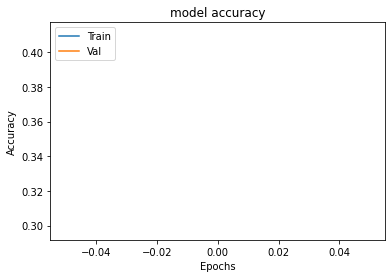

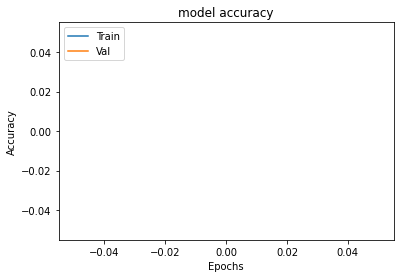

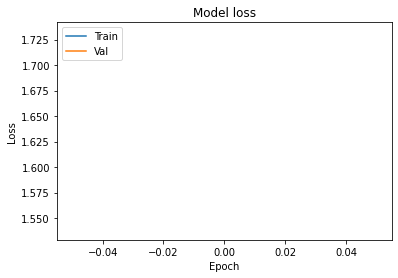

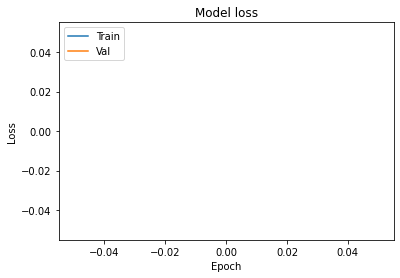

In [33]:
#Plotter de værdi vi gemte i forrige celle
#accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('model graphs/accuracy_graph.png')
plt.show()

#accuracy sidste 25
plt.plot(last_25_accuracy)
plt.plot(last_25_val_accuracy)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('model graphs/accuracy_25__graph.png')
plt.show()

#loss
plt.plot(loss_)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('model graphs/loss_graph.png')
plt.show()

#loss sidste 25
plt.plot(last_25_loss_)
plt.plot(last_25_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('model graphs/loss_25_graph.png')
plt.show()


<PIL.Image.Image image mode=RGB size=48x48 at 0x20BEFAB1730>


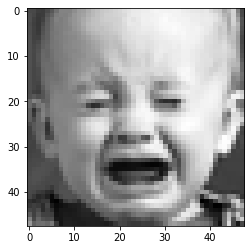

In [34]:
#Henter et testbillede og gør det gråt
import numpy as np
from keras.preprocessing import image
from PIL import Image, ImageOps 
test_image = image.load_img('data/test/sad/32869.png', target_size = (48, 48))
print(test_image)
test_image = ImageOps.grayscale(test_image) 
plt.imshow(test_image,cmap='gray')



[0.31995630264282227, 0.020668955519795418, 0.14011120796203613, 0.19512048363685608, 0.07613245397806168, 0.14757607877254486, 0.10043450444936752]


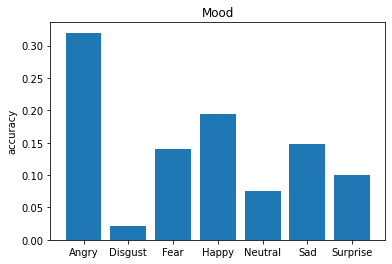

In [35]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result = result.tolist()
result = result[0]
print(result)
plt.title('Mood')
plt.ylabel('accuracy')
plt.bar(class_names, result)
plt.savefig('model graphs/predictedGraph.png')
plt.show()


In [36]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [37]:
#Test
test_ds = tf.data.Dataset.list_files(str(data_dir/'test/*/*'), shuffle=False)
test_ds = test_ds.shuffle(image_count, reshuffle_each_iteration=False)
print(tf.data.experimental.cardinality(test_ds).numpy())

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
type(test_ds)



3589


tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [38]:
numpy_images= []
numpy_labels= []
for images, labels in test_ds:  # only take first element of dataset
    label = labels.numpy()
    numpy_images.append(images.numpy())
    numpy_labels.append(label)
a = numpy_labels

test_ds = (
    test_ds
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
#loaded_model = tf.keras.models.load_model('save models')
pred = model.predict(test_ds)
pred = np.argmax(pred, axis=1)
conf = confusion_matrix(a, pred)


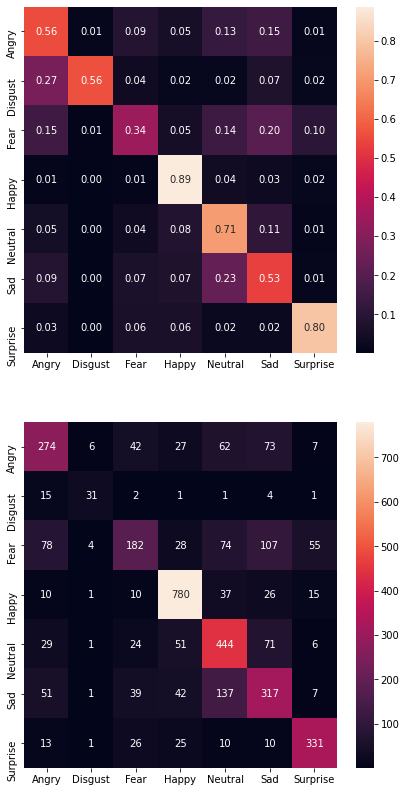

In [39]:
import seaborn as sn
import pandas as pd
cmn = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (7,14))
ax = plt.subplot(2, 1, 1)
#sn.heatmap(df_cm, annot=True, fmt="#")
sn.heatmap(cmn, annot=True, fmt='.2f',xticklabels=class_names, yticklabels=class_names)

ax = plt.subplot(2, 1, 2)
df_cm = pd.DataFrame(conf, index = [i for i in class_names],
                  columns = [i for i in class_names])
sn.heatmap(df_cm, annot=True, fmt="d")
plt.savefig('model graphs/conf.png')



In [40]:
def predict_and_save_graph():
    #imports skal måske være i GUI?
    import numpy as np
    from keras.preprocessing import image
    from PIL import Image, ImageOps

    #load den trænede model fra filsti
    loaded_model = tf.keras.models.load_model('save models')

    #load face.jpg
    test_image = image.load_img('data/test/sad/32869.png', target_size = (48, 48))
    test_image = ImageOps.grayscale(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)

    #predict med loaded_model
    result = loaded_model.predict(test_image)
    result_emotion = result.argmax(axis=-1)
    result = result.tolist()
    result = result[0]
    print(class_names[result_emotion])
    #lav (og gem) søjlediagram med predict results
    plt.title('Mood')
    plt.ylabel('Accuracy')
    plt.bar(class_names, result)
    plt.savefig('model graphs/predictedGraph.png')
    
    #Få label på den class med højest probability????????? argmax returns position af højeste value.
    #Bruges måske med class_names
    #y_prob = model.predict(x) 

['Sad']


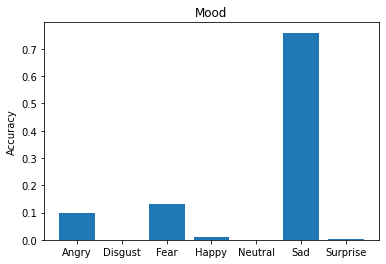

In [41]:
predict_and_save_graph()
